# Sydney Toll Roads - Fun for the whole family in the CCT
All the toll data in sydney is availble for free download! How nice of them. Let's explore the data and find out some interesting insights. Firstly download the data.... This can probably be done in Python - but I find it super easy in BASH. Or you can manually download it too, but that is no fun.
Go through the notebook and think about the interpretation for each of the visualisations. Think about how adding or removing details can help guide the message you are trying to deliver.

In [4]:
#Import the modules we will need
import pandas as pd
import numpy as np
import glob
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.dates as mdates

In [67]:
#Or load in more data, like all the CCT data
all_files = glob.glob("data/CCT*.csv")
li = []
for filename in sorted(all_files):
    df = pd.read_csv(filename, index_col=None, header=0,parse_dates=[['Date', 'IntervalStart']])
    li.append(df)
    
df = pd.concat(li, axis=0, ignore_index=True)
print("Done")

Done


In [19]:
#What does it look like?
df.head()

,Date_IntervalStart,AssetID,FinancialQtrID,IntervalEnd,Version,VehicleClass,TollPointID,GantryDirection,GantryLocation,GantryGPSLatitude,GantryGPSLongitude,GantryType,TotalVolume
0,2008-11-26,CCT,200902,00:14,1,Car,East,E,Mainline Eastbound,-33.8,151.2,Mainline Gantry,26
1,2008-11-26,CCT,200902,00:14,1,Truck,East,E,Mainline Eastbound,-33.8,151.2,Mainline Gantry,0
2,2008-11-26,CCT,200902,00:14,1,Car,SJY,N,Sir John Young,-33.8,151.2,Ramp Gantry,8
3,2008-11-26,CCT,200902,00:14,1,Truck,SJY,N,Sir John Young,-33.8,151.2,Ramp Gantry,0
4,2008-11-26,CCT,200902,00:14,1,Car,West,W,Mainline Westbound,-33.8,151.2,Mainline Gantry,16


In [20]:
#Get some other stats
#df.describe()
df.shape

(2858334, 13)

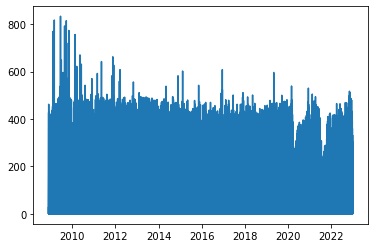

In [21]:
plt.plot(df["Date_IntervalStart"].values,df["TotalVolume"].values)

(array([13879., 14610., 15340., 16071., 16801., 17532., 18262., 18993.,
        19723.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

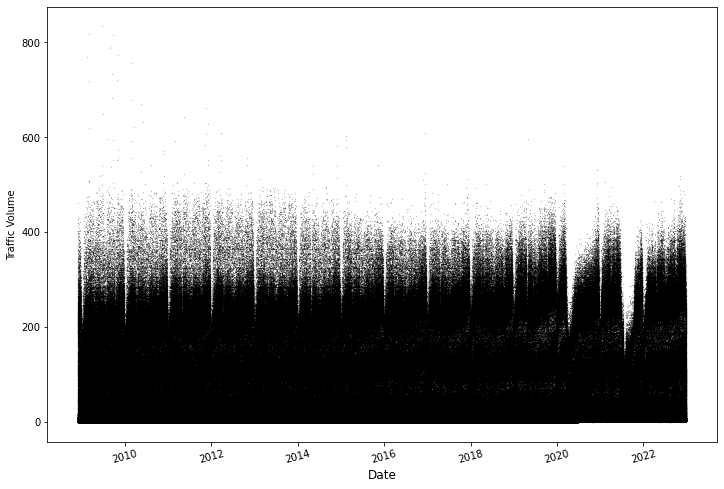

In [22]:
#Plot all the data, just time vs volume
plt.figure(figsize=(12,8)) 
plt.plot(df["Date_IntervalStart"],df["TotalVolume"].values,
         color='black', marker='.',markersize=0.2,linewidth=0.0)

plt.xlabel('Date',fontsize=12)
plt.ylabel('Traffic Volume')
plt.xticks(rotation=15)

In [36]:
# Note, 3 ways to print stuff in python
period=(df["Date_IntervalStart"][len(df)-1]-df["Date_IntervalStart"][0]).days
totalVolume=df["TotalVolume"].sum()
print("{:,} Total Trips".format(totalVolume))
print("By my count that is about", int(totalVolume/period/24/60), "per minute.")
print(f"At ~$5 a trip, that is a good income (${totalVolume*5:,}) - just for the Cross City Tunnel.")

188,385,779 Total Trips
By my count that is about 25 per minute.
At ~$5 a trip, that is a good income ($941,928,895) - just for the Cross City Tunnel.


We can continue exploring this data in several different ways. We are dealing with a hefty dataset, so keep that in mind.

In [47]:
import sys
print(sys.getsizeof(df)/1024**3,"GB")

1.3151546604931355 GB


In [48]:
#So let's load in a single month of data
filename='data/CCT_trips_2017-11.csv'
dfmonth=pd.read_csv(filename,header = 0,parse_dates=[['Date', 'IntervalStart']])

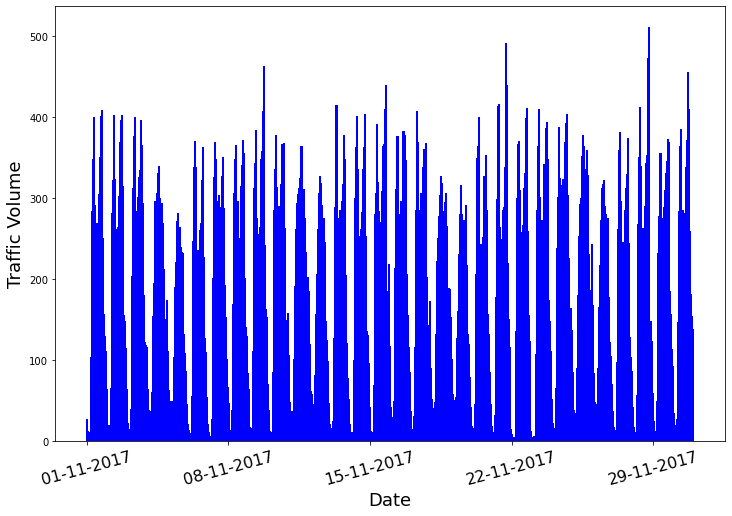

In [49]:
#Plot just the month of data
plt.figure(figsize=(12,8)) 
plt.bar(dfmonth.Date_IntervalStart.values,dfmonth["TotalVolume"].values,color='blue',width=0.1)

plt.xlabel('Date',fontsize=18)
plt.ylabel('Traffic Volume',fontsize=18)

x1=pd.to_datetime('20171101', format='%Y%m%d')
x2=pd.to_datetime('20171108', format='%Y%m%d') 
x3=pd.to_datetime('20171115', format='%Y%m%d') 
x4=pd.to_datetime('20171122', format='%Y%m%d') 
x5=pd.to_datetime('20171129', format='%Y%m%d') 

plt.xticks([x1,x2,x3,x4,x5],rotation=15,fontsize=16)
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))

plt.show()

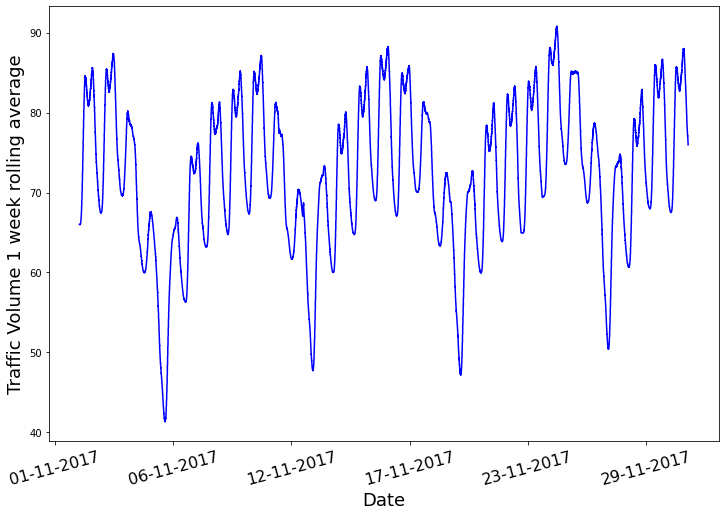

In [61]:
#Plot the rolling average
plt.figure(figsize=(12,8)) 

#4x15 minute points in 1 hour, x 24 hours in 1 day, x 7 days in 1 week
plt.plot(dfmonth.Date_IntervalStart.values,dfmonth.TotalVolume.rolling(4*24*7).mean(),color='blue')

plt.xlabel('Date',fontsize=18)
plt.ylabel('Traffic Volume 1 week rolling average',fontsize=18)

x1=pd.to_datetime('20171101', format='%Y%m%d') 
x2=pd.to_datetime('20171129', format='%Y%m%d') 

xr = pd.date_range(start=x1, end=x2, periods=6)
plt.xticks(xr,rotation=15,fontsize=16)

ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))

plt.show()

Are there more insigts we can get from this already?
Let's look at the full dataset again, but break it down into some kind of interesting subset.

In [65]:
df.GantryDirection.unique() 
# Traffic can be tolled going east, west, or north

array(['E', 'N', 'W'], dtype=object)

In [68]:
#Set the index to the date
df.set_index("Date_IntervalStart",inplace=True)
#Break up the data into interesting pieces.
#Trucks or Cars, and where they have joined the tunnel
ix_car=df.loc[(df['VehicleClass']=='Car')]
ix_truck=df.loc[(df['VehicleClass']=='Truck')]

ix_carE=df.loc[(df['VehicleClass']=='Car') & (df['GantryDirection']=='E')]
ix_carN=df.loc[(df['VehicleClass']=='Car') & (df['GantryDirection']=='N')]
ix_carW=df.loc[(df['VehicleClass']=='Car') & (df['GantryDirection']=='W')]

ix_truckE=df.loc[(df['VehicleClass']=='Truck') & (df['GantryDirection']=='E')]
ix_truckN=df.loc[(df['VehicleClass']=='Truck') & (df['GantryDirection']=='N')]
ix_truckW=df.loc[(df['VehicleClass']=='Truck') & (df['GantryDirection']=='W')]

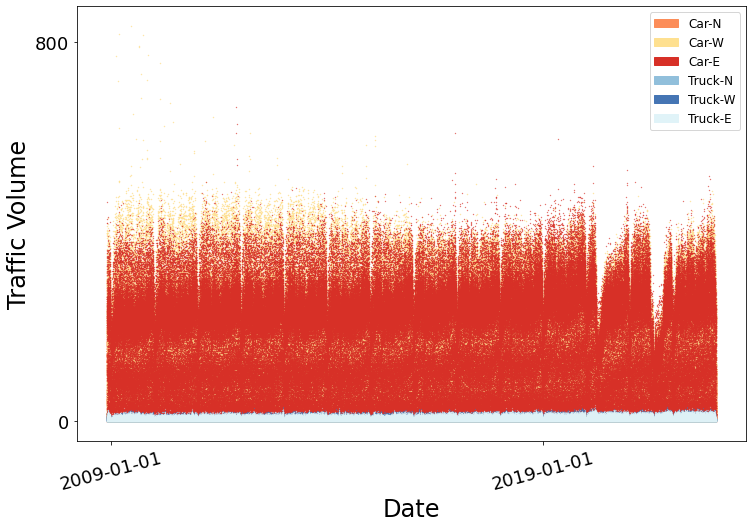

In [69]:
#Now make the same plot again, but plot each car/truck/entry seperately

#volume=pd.Series(df["TotalVolume"].values)
plt.figure(figsize=(12,8)) 

l1=plt.plot(ix_carN["TotalVolume"],
         color='#fc8d59', marker='o',markersize=0.5,linewidth=0.0)
l2=plt.plot(ix_carW["TotalVolume"],
         color='#fee090', marker='o',markersize=0.4,linewidth=0.0)
l3=plt.plot(ix_carE["TotalVolume"],
         color='#d73027', marker='o',markersize=0.3,linewidth=0.0)

l4=plt.plot(ix_truckN["TotalVolume"],
         color='#91bfdb', marker='.',markersize=0.5,linewidth=0.0)
l5=plt.plot(ix_truckW["TotalVolume"],
         color='#4575b4', marker='.',markersize=0.4,linewidth=0.0)
l6=plt.plot(ix_truckE["TotalVolume"],
         color='#e0f3f8', marker='.',markersize=0.3,linewidth=0.0)



plt.xlabel('Date',fontsize=24)
plt.ylabel('Traffic Volume',fontsize=24)
plt.yticks([0,800],fontsize=18)

x1=pd.to_datetime('20090101', format='%Y%m%d')
x2=pd.to_datetime('20190101', format='%Y%m%d') 

plt.xticks([x1,x2],rotation=15,fontsize=18)

carN = mpatches.Patch(color='#fc8d59', label='Car-N')
carW = mpatches.Patch(color='#fee090', label='Car-W')
carE = mpatches.Patch(color='#d73027', label='Car-E')
truckN = mpatches.Patch(color='#91bfdb', label='Truck-N')
truckW = mpatches.Patch(color='#4575b4', label='Truck-W')
truckE = mpatches.Patch(color='#e0f3f8', label='Truck-E')
plt.legend(handles=[carN,carW,carE,truckN,truckW,truckE],fontsize=12)


2020-01-15 00:00:00


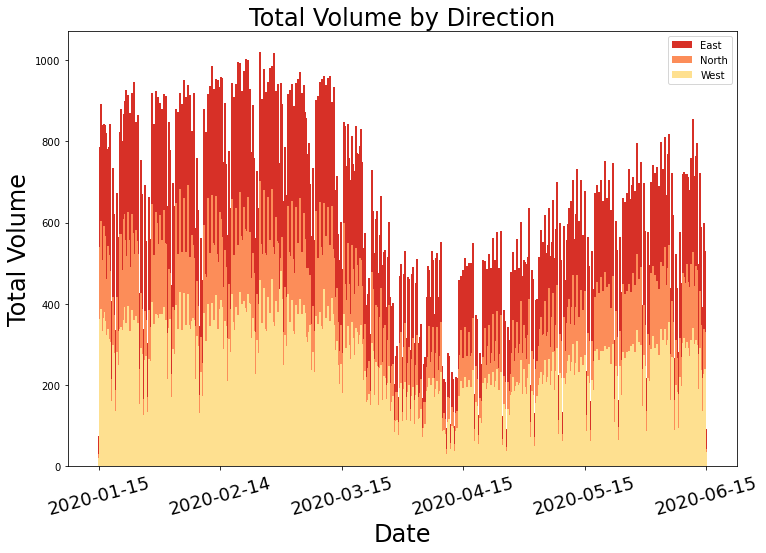

In [108]:
fig, ax = plt.subplots(figsize=(12, 8))

# Set the range of interest
x1=pd.to_datetime('20200115', format='%Y%m%d')
x2=pd.to_datetime('20200615', format='%Y%m%d')

# Define the x-axis values for the bar chart
x_values = ix_carW.loc[x1:x2].index.to_frame().index.values

# Define the y-axis values for each bar
y_values_w = ix_carW.loc[x1:x2]["TotalVolume"]
y_values_n = ix_carN.loc[x1:x2]["TotalVolume"]
y_values_e = ix_carE.loc[x1:x2]["TotalVolume"]

# Plot the stacked bar chart
ax.bar(x_values, y_values_e, bottom=y_values_w+y_values_n, label='East',color='#d73027',width=0.5)
ax.bar(x_values, y_values_n, bottom=y_values_w, label='North',color='#fc8d59',width=0.5)
ax.bar(x_values, y_values_w, label='West', color='#fee090',width=0.5)

# Set the chart title and axis labels
ax.set_title('Total Volume by Direction', fontsize=24)
ax.set_xlabel('Date',fontsize=24)
ax.set_ylabel('Total Volume',fontsize=24)

# Add a legend to the chart
ax.legend()

xr = pd.date_range(start=x1, end=x2, periods=6)
print(x1)
plt.xticks(xr,rotation=15,fontsize=18)

# Show the chart
plt.show()

2020-01-15 00:00:00


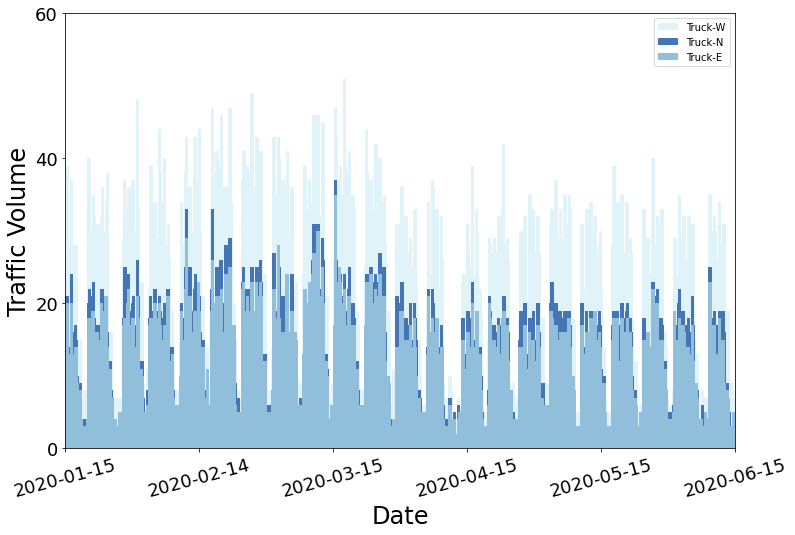

In [109]:
#volume=pd.Series(df["TotalVolume"].values)
plt.figure(figsize=(12,8)) 

# Define the x-axis values for the bar chart
x_values = ix_truckW.loc[x1:x2].index.to_frame().index.values

#Restrict the axis, so we don't waste time plotting the the whole dataset.
x1=pd.to_datetime('20200115', format='%Y%m%d')
x2=pd.to_datetime('20200615', format='%Y%m%d')

plt.bar(x_values,ix_truckW.loc[x1:x2]["TotalVolume"],
        color='#e0f3f8',bottom=ix_truckN.loc[x1:x2]["TotalVolume"]+ix_truckE.loc[x1:x2]["TotalVolume"],label='Truck-W')

plt.bar(x_values,ix_truckN.loc[x1:x2]["TotalVolume"],
        color='#4575b4',bottom=ix_truckE.loc[x1:x2]["TotalVolume"],label='Truck-N')

plt.bar(x_values,ix_truckE.loc[x1:x2]["TotalVolume"],
        color='#91bfdb',label='Truck-E')

plt.xlabel('Date',fontsize=24)
plt.ylabel('Traffic Volume',fontsize=24)

plt.yticks([0,20,40,60],fontsize=18)        

xr = pd.date_range(start=x1, end=x2, periods=6)
print(x1)
plt.xticks(xr,rotation=15,fontsize=18)

#plt.ylim([0,30])
plt.xlim([x1,x2])

plt.legend()

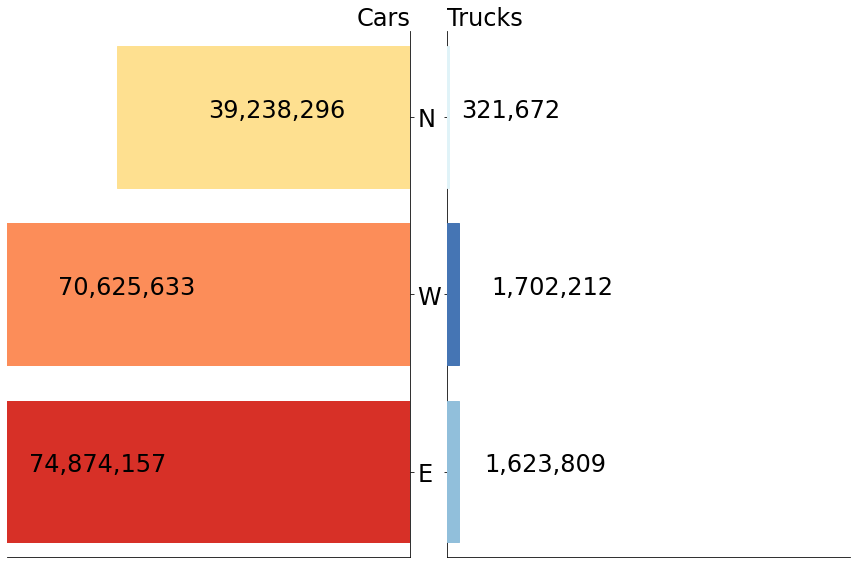

In [110]:
#Plot some totals in a fancy way.

# Data
states = ["E", "N", "W"]
trucks = np.array([ix_truckE["TotalVolume"].sum(),
                  ix_truckN["TotalVolume"].sum(),
                  ix_truckW["TotalVolume"].sum()])

cars = np.array([ix_carE["TotalVolume"].sum(),
                  ix_carN["TotalVolume"].sum(),
                  ix_carW["TotalVolume"].sum()])


# Sort by number of sales staff
idx = cars.argsort()[::-1]
states, trucks, cars = [np.take(x, idx) for x in [states, trucks, cars]]

y = np.arange(cars.size)

fig, axes = plt.subplots(ncols=2, sharey=True,figsize=(12,8))

barlist=axes[1].barh(y, trucks, align='center', color='#e0f3f8', zorder=10)
axes[1].set_title('Trucks',loc='left',fontsize=24)
barlist[0].set_color('#91bfdb')
barlist[1].set_color('#4575b4')
barlist[2].set_color('#e0f3f8')

barlist=axes[0].barh(y, cars, align='center', color='#d73027', zorder=10)
#axes[0].set(title='Number of Cars')
axes[0].set_title('Cars',loc='right',fontsize=24)
barlist[0].set_color('#d73027')
barlist[1].set_color('#fc8d59')
barlist[2].set_color('#fee090')
 
axes[1].set(xticks=[])
axes[0].set(xticks=[])

axes[1].set_xlim([0,54000000])
axes[0].set_xlim([0,54000000])

axes[0].invert_xaxis()
axes[0].set(yticks=y, yticklabels=states)
axes[0].set_yticklabels(states,fontsize=24)
axes[0].yaxis.tick_right()

axes[0].spines["top"].set_visible(False)
axes[0].spines["left"].set_visible(False)
#axes[0].spines["bottom"].set_visible(False)

axes[1].spines["top"].set_visible(False)
axes[1].spines["right"].set_visible(False)
#axes[1].spines["bottom"].set_visible(False)
#axes[0].axis('off')
#axes[1].axis('off')

for ax in axes.flat:
    ax.margins(0.03)

fig.tight_layout()
fig.subplots_adjust(wspace=0.09)

axes[1].text(2000000,2,"{:,}".format(ix_truckN["TotalVolume"].sum()),fontsize=24)
axes[1].text(6000000,1,"{:,}".format(ix_truckW["TotalVolume"].sum()),fontsize=24)
axes[1].text(5000000,0,"{:,}".format(ix_truckE["TotalVolume"].sum()),fontsize=24)
axes[1].text(-32000000,2,"{:,}".format(ix_carN["TotalVolume"].sum()),fontsize=24)
axes[1].text(-52000000,1,"{:,}".format(ix_carW["TotalVolume"].sum()),fontsize=24)
axes[1].text(-56000000,0,"{:,}".format(ix_carE["TotalVolume"].sum()),fontsize=24)

plt.show()